In [2]:
import os
import re
import librosa
import pickle
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import Transformer
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE

from data.BabyChillanto import SegmentedAudio
from utils import flatten_list, center_data, generate_train_val_ids

ModuleNotFoundError: No module named 'model'

In [4]:
ce = [50.69637883008357, 31.836734693877553, 51.19760479041916, 82.25255972696246, 81.67202572347267, 55.43478260869565, 45.853658536585364, 52.81385281385281, 85.90163934426229, 30.736842105263158]
ce_self = [49.02506963788301, 49.795918367346935, 48.80239520958084, 66.89419795221843, 59.48553054662379, 52.71739130434783, 36.58536585365854, 52.81385281385281, 73.77049180327869, 20.42105263157895]
self = [4.735376044568246, 4.8979591836734695, 23.05389221556886, 1.7064846416382253, 7.395498392282958, 36.41304347826087, 12.682926829268293, 2.5974025974025974, 64.59016393442623, 2.1052631578947367]
dp = [50.69637883008357, 37.55102040816327, 36.52694610778443, 75.42662116040955, 69.7749196141479, 42.93478260869565, 44.390243902439025, 61.47186147186147, 71.47540983606558, 18.94736842105263]
import numpy as np

print(np.mean(ce), np.mean(ce_self), np.mean(self), np.mean(dp))
print(np.var(ce), np.var(ce_self), np.var(self), np.var(dp))

56.839607917347465 51.031126612036985 16.01780104749845 50.91955523607031
362.2009601904873 200.23881894896897 373.9635997664779 300.45393300895694


In [ ]:
# hyper parameter
labels = ['asphyxia', 'deaf', 'hunger', 'normal', 'pain']
data_dir = "dataset/BabyChillantoDB/"
checkpoint_path = './checkpoint/best_model.pth'
pattern = r'^\d+'
n_mfcc_coeffs=20
seg_len = 4
val_rate = 0.2
n_dim = 128 # Transformer dim

In [ ]:
def get_dataset_ids(labels, data_dir, prefix='Full_'):
    full_audio_dirs = [data_dir + prefix + label for label in labels]
    
    id2audios = {}
    n_baby = 0
    baby_ids = []

    for idx, dir in enumerate(full_audio_dirs):
        class_ids = []
        for file in os.listdir(dir):
            if file.lower().endswith(".wav"):
                # record individual ids
                _id = int(re.findall(r'\d+', file)[0])
                
                if _id in id2audios:
                    id2audios[_id].append(file)
                else:
                    id2audios[_id] = [file]
                    n_baby += 1
                    class_ids.append(_id)

        baby_ids.append(class_ids)
        
    print("Total baby number: {}, class distribution: {}".format(n_baby, [f"{labels[i]}: {len(cls)}" \
            for i, cls in enumerate(baby_ids)]))
    
    return baby_ids, id2audios, n_baby

baby_ids, id2audios, n_baby = get_dataset_ids(labels, data_dir)

Total baby number: 73, class distribution: ['asphyxia: 6', 'deaf: 6', 'hunger: 33', 'normal: 5', 'pain: 23']


In [3]:
train_ids, val_ids = generate_train_val_ids(baby_ids, n_baby, save_path=None, load_path=None)

def read_one_second_audio(data_dir, labels, train_ids, val_ids, n_mfcc_coeffs, prefix='1s_'):
    data_idx = 0 
    train_data = {'audio': [], 'label': [], 'id': []}
    val_data = {'audio': [], 'label': [], 'id': []}
    one_second_audio_dirs = [data_dir + prefix + label for label in labels]
    for i, dir in enumerate(one_second_audio_dirs):
        for file in os.listdir(dir):
            if file.endswith(".wav"):
                if data_idx == 1921: # dirty data
                    #print(dir + '/' + file)
                    data_idx += 1
                    continue
                
                y, sr = librosa.load(os.path.join(dir, file))
                print(y.shape, sr)
                
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_coeffs).T
                #n_frames = mfcc.shape[0]
                pitch = librosa.yin(y, fmin=75, fmax=600)
                #intensity = librosa.feature.rms(y=y).flatten()
                feature = np.concatenate((mfcc, pitch), axis=0)
                
                _id = int(file[2:4])
                if _id in train_ids:
                    train_data['audio'].append(feature)
                    train_data['label'].append(i)
                    train_data['id'].append(_id)
                elif _id in val_ids:
                    val_data['audio'].append(feature)
                    val_data['label'].append(i)
                    val_data['id'].append(_id)
                else:
                    print('Data {}/{} is not included.'.format(dir, file))
                
                data_idx += 1
        
    for data in [train_data, val_data]:
        data['audio'] = torch.from_numpy(center_data(np.stack(data['audio']))).float()
        data['label'] = torch.tensor(data['label'])
        data['id'] = torch.tensor(data['id'])
        
    return train_data, val_data

def read_n_seconds_audio(data_dir, labels, n, train_ids, val_ids, n_mfcc_coeffs, prefix='Full_'):
    data_idx = 0 
    train_data = {'audio': [], 'label': [], 'id': []}
    val_data = {'audio': [], 'label': [], 'id': []}
    full_audio_dirs = [data_dir + prefix + label for label in labels]
    for i, dir in enumerate(full_audio_dirs):
        for file in os.listdir(dir):
            if file.endswith(".wav"):
                y, sr = librosa.load(os.path.join(dir, file))
                seg_samples = int(n * sr)
                total_segs = len(y) // seg_samples
                _id = int(re.findall(r'\d+', file)[0])
                for seg_index in range(total_segs):
                    start = seg_index * seg_samples
                    end = (seg_index + 1) * seg_samples
                    segment = y[start:end]
                    
                    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc_coeffs).T

                    #n_frames = mfcc.shape[0]
                    pitch = librosa.yin(segment, fmin=75, fmax=600)
                    #intensity = librosa.feature.rms(y=y).flatten()
                    feature = np.concatenate((mfcc, np.expand_dims(pitch, axis=1)), axis=1)
                    if _id in train_ids:
                        train_data['audio'].append(feature)
                        train_data['label'].append(i)
                        train_data['id'].append(_id)
                    elif _id in val_ids:
                        val_data['audio'].append(feature)
                        val_data['label'].append(i)
                        val_data['id'].append(_id)
                    else:
                        print('Data {}/{} is not included.'.format(dir, file))

    for data in [train_data, val_data]:
        data['audio'] = torch.from_numpy(center_data(np.stack(data['audio']))).float()
        data['label'] = torch.tensor(data['label'])
        data['id'] = torch.tensor(data['id'])
    
    print('Training samples: {}, validation samples: {}'.format(train_data['audio'].shape[0], val_data['audio'].shape[0]))
    return train_data, val_data

train_data, val_data = read_one_second_audio(data_dir, labels, train_ids, val_ids, n_mfcc_coeffs)

NameError: name 'generate_train_val_ids' is not defined

In [ ]:
n_frames = train_data['audio'].shape[1]
n_mfcc_coeffs = train_data['audio'].shape[2]
model = MLP(n_frames * n_mfcc_coeffs, 2000, 64, len(labels))

#model = TransformerModel(dim, n_dim, len(labels))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the dataloader
train_dataset = SegmentedAudio(train_data)
val_dataset = SegmentedAudio(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_model = None
best_performance = float('-inf') 
best_epoch = -1
# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_data in train_loader:
        b_audios, b_labels, b_ids = batch_data
        optimizer.zero_grad()
        outputs = model(b_audios)
        loss = criterion(outputs, b_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    total_loss = 0
    correct = 0
    id2wrongCount = {id : 0 for id in val_data['id'].tolist()}
    wrong_ids = []
    with torch.no_grad():
        for vb_audios, vb_labels, vb_ids in val_loader:
            # Compute predictions and loss
            voutputs = model(vb_audios)
            loss = criterion(voutputs, vb_labels)
            total_loss += loss.item()
            
            pred = voutputs.argmax(dim=1, keepdim=True)
            correct += pred.squeeze(1).eq(vb_labels).sum().item()
            correct_indices = torch.nonzero(pred.squeeze(1).eq(vb_labels)).squeeze()
            mistake_indices = torch.nonzero(torch.ne(pred.squeeze(1), vb_labels)).squeeze()
            #wrong_ids = [vb_ids[mistake_indices]] if len(mistake_indices) == 1 else vb_ids[mistake_indices].tolist()
            if len(mistake_indices.shape) != 0:
                wrong_ids.extend(vb_ids[mistake_indices].tolist())
                
            for id in wrong_ids:
                id2wrongCount[id] += 1
            #wrong_ids = torch.tensor([elem for i, elem in enumerate(vb_ids) if i not in correct_indices])
            #print(torch.unique(wrong_ids))
            
    avg_loss = total_loss / len(val_loader)
    val_accuracy = 100. * correct / len(val_dataset)

    # Check if current model has better performance than previous best model
    if val_accuracy > best_performance:
        best_performance = val_accuracy
        best_model = model.state_dict()  # Save the model's state dictionary
        torch.save(best_model, checkpoint_path)
        
print(f"Epoch [{epoch+1}/{num_epochs}]: Traininn loss = {running_loss / len(train_loader): .3f}, \
        Val Accuracy = {val_accuracy: .3f}, {correct}/{len(val_dataset)}, Best Val Accuracy = {best_performance: .3f}")
print(id2wrongCount)

Epoch [20/20]: Traininn loss =  1.041,         Val Accuracy =  44.231, 23/52, Best Val Accuracy =  76.923
{65: 10, 26: 0, 38: 6, 46: 5, 51: 2, 35: 2, 40: 4, 71: 5, 20: 1, 7: 1, 2: 2}


In [ ]:
model.load_state_dict(torch.load(checkpoint_path)) 
model.eval()
all_data = {'audio': [], 'label': [], 'id': []}
all_data['audio'] = torch.cat([train_data['audio'], val_data['audio']], axis=0)
all_data['label'] = torch.cat([train_data['label'], val_data['label']], axis=0)
all_data['id'] = torch.cat([train_data['id'], val_data['id']], axis=0)
all_dataset = SegmentedAudio(all_data)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=True)

correct = 0
id2wrongCount = {id : 0 for id in all_data['id'].tolist()}
wrong_ids = []

with torch.no_grad():
    for b_audios, b_labels, b_ids in all_loader:
        # Compute predictions and loss
        outputs = model(b_audios)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()
        
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.squeeze(1).eq(b_labels).sum().item()
        correct_indices = torch.nonzero(pred.squeeze(1).eq(b_labels)).squeeze()
        mistake_indices = torch.nonzero(torch.ne(pred.squeeze(1), b_labels)).squeeze()
        #wrong_ids = [b_ids[mistake_indices]] if len(mistake_indices) == 1 else b_ids[mistake_indices].tolist()
        if len(mistake_indices.shape) != 0:
            wrong_ids.extend(b_ids[mistake_indices].tolist())
            
        for id in wrong_ids:
            id2wrongCount[id] += 1
        #wrong_ids = torch.tensor([elem for i, elem in enumerate(b_ids) if i not in correct_indices])
        #print(torch.unique(wrong_ids))
        
avg_loss = total_loss / len(all_loader)
all_accuracy = 100. * correct / len(all_dataset)

print(f"Inference loss = {avg_loss: .3f}, Accuracy = {all_accuracy: .3f}, {correct}/{len(all_dataset)}")

Inference loss =  1.177, Accuracy =  90.807, 484/533


In [ ]:
import torch

vocoder = torch.hub.load('seungwonpark/melgan', 'melgan')
vocoder.eval()
#mel = torch.randn(1, 80, 234) # use your own mel-spectrogram here

if torch.cuda.is_available():
    vocoder = vocoder.cuda()
    mel = mel.cuda()

with torch.no_grad():
    audio = vocoder.inference(mel)

Using cache found in /home/minghao.fu/.cache/torch/hub/seungwonpark_melgan_master


ModuleNotFoundError: No module named 'model.generator'

In [ ]:
id2label = {_id: label for _id, label in zip(train_data['id'].tolist(), train_data['label'].tolist())}
label_num = [[] for _ in range(5)]
print(label_num)
for _id in train_ids:
    label_num[id2label[_id]].append(_id)
    
import pickle

data = {'train': train_ids, 'val': val_ids}
with open("ids_split.pkl", "wb") as file:
    pickle.dump(data, file)
    
with open("ids_split.pkl", "rb") as file:
    data = pickle.load(file)
t_train_ids = data['train']
t_val_ids = data['val']

t_val_ids == val_ids


[[], [], [], [], []]


KeyError: 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


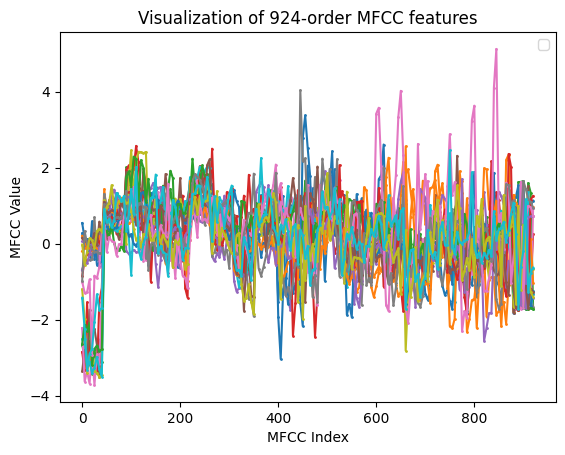

In [ ]:
def plot_MFCC_feature(data, slices: tuple, step):
    # plot_MFCC_feature(train_data['audio'], (0, 20), 5)
    X_axis = torch.arange(0, data.shape[1]).unsqueeze(0).repeat(data.shape[0], 1)
    for i in range(slices[0], slices[1]): 
        plt.plot(X_axis[i, ::step], train_data['audio'][i, ::step], '-o', markersize=1)
    plt.title(f'Visualization of {data.shape[1]}-order MFCC features')
    plt.xlabel('MFCC Index')
    plt.ylabel('MFCC Value')
    plt.legend()
    plt.show()


In [ ]:
# Evaluate the model on the test set
model.load_state_dict(torch.load('./best_model.pth'), strict=True)
model.eval()
val_loss = 0
correct = 0
with torch.no_grad():
    for b_audios, b_labels, b_ids in val_loader:
        # Compute predictions and loss
        outputs = model(b_audios)
        pred = outputs.argmax(dim=1, keepdim=True)
        loss = criterion(outputs, b_labels)
        val_loss += loss.item()
        correct += pred.squeeze(1).eq(b_labels).sum().item()
        # output = model(b_audios)
        # val_loss += F.cross_entropy(output, b_labels, reduction='sum').item()
        # pred = output.argmax(dim=1, keepdim=True)
        # correct += pred.squeeze(1).eq(b_labels).sum().item()

val_loss /= len(val_dataset)
val_accuracy = 100. * correct / len(val_dataset)
print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
    val_loss, correct, len(val_dataset), val_accuracy))


Validation set: Average loss: 0.0449, Accuracy: 328/577 (56.846%)


In [ ]:
# Check outlier
model.eval()
val_loss = 0
correct = 0
output_labels = []
with torch.no_grad():
    for audio, label, id in val_dataset:
        output = model(audio.unsqueeze(0))
        output_labels.append(output.argmax(axis=1, keepdim=True))
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label).sum().item()
        
output_labels = torch.cat(output_labels, dim=0).squeeze(1)
outlier_indices = torch.nonzero(~(output_labels == val_dataset['label'].argmax(dim=1, keepdim=True).squeeze(1))).squeeze(1)


count_dict = {key: 0 for key in label_interval.keys()}

for key, interval in label_interval.items():
    count = torch.sum((outlier_indices >= interval[0]) & (outlier_indices <= interval[1]))
    count_dict[key] = count.item()

print("Count Dictionary:", count_dict)

keys = list(count_dict.keys())
values = list(count_dict.values())

# Set up the figure and axes
fig, ax = plt.subplots()

# Plot the histogram
ax.bar(keys, values)

# Set labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Misclassification')

# Rotate x-axis labels if needed
plt.xticks(rotation='vertical')

# Display the plot
plt.show()
outlier_indices

ValueError: too many values to unpack (expected 2)

In [ ]:
torch.corrcoef(torch.stack([X_tensor[2264], X_tensor[1240]], dim=0))

tensor([[1.0000, 0.1599],
        [0.1599, 1.0000]])

/apps/local/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/apps/local/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


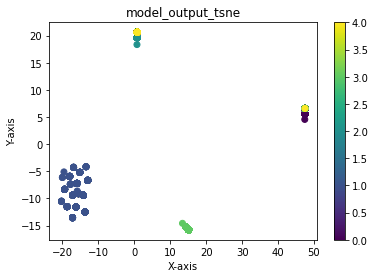

<Figure size 432x288 with 0 Axes>

In [ ]:
model.eval()
embeddings = []
with torch.no_grad():
    for batch in dataset:
        data, label = batch
        output = model(data.unsqueeze(0))
        embeddings.append(output)
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.argmax(dim=1, keepdim=True)

# perform t-SNE on the embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# plot the t-SNE embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_tensor.argmax(axis=1, keepdim=True))
plt.colorbar()
plt.title('model_output_tsne')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
# save the plot to a file
plt.savefig('model_output_tsne.png')

/apps/local/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/apps/local/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


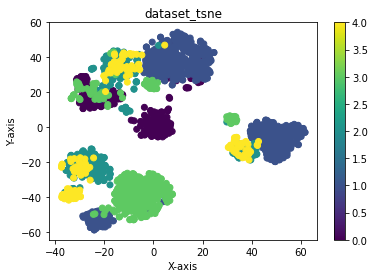

<Figure size 432x288 with 0 Axes>

In [ ]:
embeddings=[]

with torch.no_grad():
    for batch in dataset:
        data, label = batch
        embeddings.append(data.unsqueeze(0))
#embeddings = torch.cat(X_tensor, dim=0)
#embeddings = embeddings.argmax(dim=1, keepdim=True)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(X_tensor)

# plot the t-SNE embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_tensor.argmax(dim=1, keepdim=True))
plt.colorbar()
plt.title('dataset_tsne')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
# save the plot to a file
plt.savefig('dataset_tsne.png')

/apps/local/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


ValueError: 'y1' is not 1-dimensional

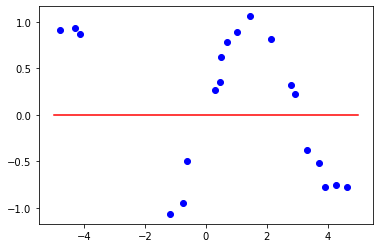

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Generate synthetic data
np.random.seed(0)
X = np.random.uniform(-5, 5, size=(20, 1))
y = np.sin(X) + np.random.normal(0, 0.1, size=(20, 1))

# Define the kernel function
kernel = RBF(length_scale=1.0)

# Create a GP regression model
model = GaussianProcessRegressor(kernel=kernel)

# Fit the model to the training data
model.fit(X, y)

# Generate test data for predictions
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)

# Make predictions with the trained model
y_pred, y_std = model.predict(X_test, return_std=True)

# Plot the results
plt.scatter(X, y, color='blue', label='Training Data')
plt.plot(X_test, y_pred, color='red', label='GP Regression')
plt.fill_between(X_test.squeeze(), (y_pred - 2 * y_std).squeeze(), (y_pred + 2 * y_std).squeeze(),
                 color='gray', alpha=0.3, label='Uncertainty')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


In [ ]:
import torch
import torchaudio

# Load the pre-trained Wav2Vec2 model from a GitHub repository
model = torch.hub.load('pytorch/fairseq', 'wav2vec2_large', pretrained=True)

# Switch the model to evaluation mode
model.eval()

# Load input audio file and preprocess it
audio, _ = torchaudio.load('input.wav')
features = model.feature_extractor(audio)

# Perform inference using the model
with torch.no_grad():
    output = model(features)

Downloading: "https://github.com/pytorch/fairseq/zipball/main" to /home/minghao.fu/.cache/torch/hub/main.zip
/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-06-18 22:35:01.075755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 22:35:02.843524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No CUDA runtime is found, using CUDA_HOME='/usr'
2023-06-18 22:35:09 | INFO | root | running build_ext
2023-06-18 22:35:09 | INFO | root | cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp
2023-06-18 22:35:11 | INFO | root | cythoning fairseq/data/token_block_utils_fast.

[1/2] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbleu/module.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/fairseq/clib/libbleu/module.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbleu/module.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi1011"' -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX11_ABI=0
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
[2/2] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbleu/libbleu.o.d -pthread -B /ho

2023-06-18 22:35:13 | INFO | root | building 'fairseq.data.data_utils_fast' extension
2023-06-18 22:35:13 | INFO | root | creating /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data
Emitting ninja build file /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
2023-06-18 22:35:19 | INFO | root | creating build/lib.linux-x86_64-cpython-38/fairseq/data
2023-06-18 22:35:19 | INFO | root | g++ -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /home/minghao.fu/MyEnv/compiler_compat -L/home/minghao.fu/MyEnv/lib -Wl,-rpath=/home/minghao.fu/MyEnv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/data_utils_fast.o -o build/lib.linux-

[1/1] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/data_utils_fast.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/numpy/core/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/numpy/core/include -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/fairseq/data/data_utils_fast.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/data_utils_fast.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi1011"' -DTORCH_EXTENSION_NAME=data_utils_fast -D_GLIBCXX_USE_CXX11_ABI=0
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In

Emitting ninja build file /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
2023-06-18 22:35:25 | INFO | root | g++ -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /home/minghao.fu/MyEnv/compiler_compat -L/home/minghao.fu/MyEnv/lib -Wl,-rpath=/home/minghao.fu/MyEnv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/token_block_utils_fast.o -o build/lib.linux-x86_64-cpython-38/fairseq/data/token_block_utils_fast.cpython-38-x86_64-linux-gnu.so
2023-06-18 22:35:25 | INFO | root | building 'fairseq.libbase' extension
2023-06-18 22:35:25 | INFO | root | creating /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbase


[1/1] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/token_block_utils_fast.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/numpy/core/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/numpy/core/include -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/fairseq/data/token_block_utils_fast.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/data/token_block_utils_fast.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi1011"' -DTORCH_EXTENSION_NAME=token_block_utils_fast -D_GLIBCXX_USE_CXX11_ABI=0
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid f

Emitting ninja build file /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
2023-06-18 22:35:57 | INFO | root | g++ -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /home/minghao.fu/MyEnv/compiler_compat -L/home/minghao.fu/MyEnv/lib -Wl,-rpath=/home/minghao.fu/MyEnv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbase/balanced_assignment.o -L/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/lib -lc10 -ltorch -ltorch_cpu -ltorch_python -o build/lib.linux-x86_64-cpython-38/fairseq/libbase.cpython-38-x86_64-linux-gnu.so


[1/1] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbase/balanced_assignment.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/TH -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/THC -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/fairseq/clib/libbase/balanced_assignment.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libbase/balanced_assignment.o -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cx

2023-06-18 22:35:57 | INFO | root | building 'fairseq.libnat' extension
2023-06-18 22:35:57 | INFO | root | creating /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libnat
Emitting ninja build file /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
2023-06-18 22:36:25 | INFO | root | g++ -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /home/minghao.fu/MyEnv/compiler_compat -L/home/minghao.fu/MyEnv/lib -Wl,-rpath=/home/minghao.fu/MyEnv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libnat/edit_dist.o -L/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/lib -lc10 -ltorch -ltorch_cpu -ltorch_python -o build/lib.

[1/1] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libnat/edit_dist.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/TH -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/THC -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/fairseq/clib/libnat/edit_dist.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/fairseq/clib/libnat/edit_dist.o -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi1011"' -DTORCH_EXTENSION_NAME

2023-06-18 22:36:26 | INFO | root | building 'alignment_train_cpu_binding' extension
2023-06-18 22:36:26 | INFO | root | creating /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/examples
2023-06-18 22:36:26 | INFO | root | creating /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/examples/operators
Emitting ninja build file /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
2023-06-18 22:36:53 | INFO | root | g++ -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /home/minghao.fu/MyEnv/compiler_compat -L/home/minghao.fu/MyEnv/lib -Wl,-rpath=/home/minghao.fu/MyEnv/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpyt

[1/1] c++ -MMD -MF /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/examples/operators/alignment_train_cpu.o.d -pthread -B /home/minghao.fu/MyEnv/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/TH -I/home/minghao.fu/MyEnv/lib/python3.8/site-packages/torch/include/THC -I/home/minghao.fu/MyEnv/include/python3.8 -c -c /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/examples/operators/alignment_train_cpu.cpp -o /home/minghao.fu/.cache/torch/hub/pytorch_fairseq_main/build/temp.linux-x86_64-cpython-38/examples/operators/alignment_train_cpu.o -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi10

2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/fairseq/libbleu.cpython-38-x86_64-linux-gnu.so -> fairseq
2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/fairseq/data/data_utils_fast.cpython-38-x86_64-linux-gnu.so -> fairseq/data
2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/fairseq/data/token_block_utils_fast.cpython-38-x86_64-linux-gnu.so -> fairseq/data
2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/fairseq/libbase.cpython-38-x86_64-linux-gnu.so -> fairseq
2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/fairseq/libnat.cpython-38-x86_64-linux-gnu.so -> fairseq
2023-06-18 22:36:54 | INFO | root | copying build/lib.linux-x86_64-cpython-38/alignment_train_cpu_binding.cpython-38-x86_64-linux-gnu.so -> 


RuntimeError: Cannot find callable wav2vec2_large in hubconf